# Intermediate Machine Learning: Assignment 2

**Deadline**

Assignment 2 is due Wednesday, October 11 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:

Go to "File" at the top-left of your Jupyter Notebook
Under "Download as", select "HTML (.html)"
After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * Convolutional neural networks
 * Gaussian processes
 * Double descent
 
This assignment will also help to solidify your Python and Jupyter notebook skills.


## Problem 1: It's not a bug, it's a feature! (20 points)

In this problem, we will ["open the black box"](https://news.yale.edu/2018/12/10/why-take-ydata-because-data-science-shouldnt-be-black-box) and inspect the filters and feature maps learned by a convolutional neural network trained to classify handwritten digits, using the MNIST database.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### 1.1 Visualizing the filters

To begin, we load the dataset with 60000 training images and 10000 test images.

In [7]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train_binary = keras.utils.to_categorical(y_train, num_classes)
y_test_binary = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Next, we initialize our convolutional neural network similar to the network we used for Problem 1 except that we now have a few more layers.

In [8]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5

2022-09-23 10:38:28.357621: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
batch_size = 128
epochs = 1

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train_binary, batch_size=batch_size, epochs=epochs, validation_split=0.1)

2022-09-23 10:38:30.343598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


422/422 [==============================] - 9s 20ms/step - loss: 0.8358 - accuracy: 0.7279 - val_loss: 0.0773 - val_accuracy: 0.9777


In [10]:
score = model.evaluate(x_test, y_test_binary, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08751484006643295
Test accuracy: 0.9739000201225281


Now that we've trained and tested the model, let's look at the filters learned in the first convolutional layer.

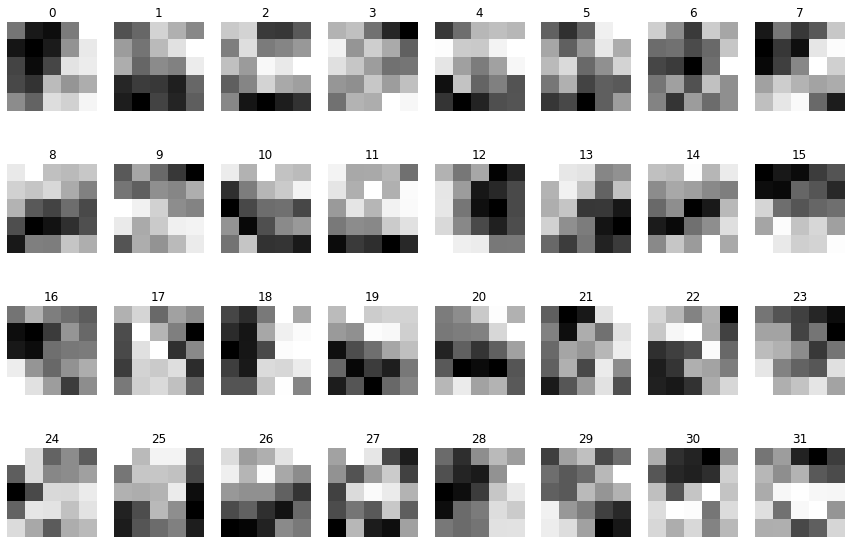

In [11]:
filters_conv1 = model.get_layer(name='conv1').get_weights()[0]

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(8):
        f = filters_conv1[:, :, 0, 8*i+j]
        axs[i, j].imshow(f[:, :], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(8*i+j)

Describe what you see. Do (some of) the learned filters make sense to you?

Hint: Many filters have been designed and widely applied in image processing. [Here](http://www.theobjects.com/dragonfly/dfhelp/3-5/Content/05_Image%20Processing/Edge%20Detection%20Filters.htm) are some examples of edge detection filters and their effect on the image. You can find the details about each filter by clicking the links at the bottom.

For example, filter #13 is an edge detector with respect to a horizontal edge, 
and filter #30 is an edge detector for a vertical edge.

### 1.2 Visualizing the feature maps

We can also look at the corresponding feature map for each filter. There are 32 kernels at the first convolutional layer, so there are 32 feature maps for each sample. feature_map_conv1 is a 4D matrix where the first dimension is the index of the sample and the last dimension is the index of the correpsonding filter.

In [12]:
conv1_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('conv1').output)
feature_map_conv1 = conv1_layer_model(x_test)

Randomly draw 16 samples for visualization.

In [13]:
sample_index = random.sample(range(1, len(x_test)), 16)

Choose two filters among all 32 filters from 2.1, visualize their feature maps. There is no need to modify the code, just run the four cells below.

In [14]:
filter_n1 = 13
filter_n2 = 30

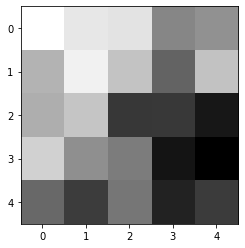

In [15]:
plt.imshow(filters_conv1[:, :, 0, filter_n1], cmap='gray')

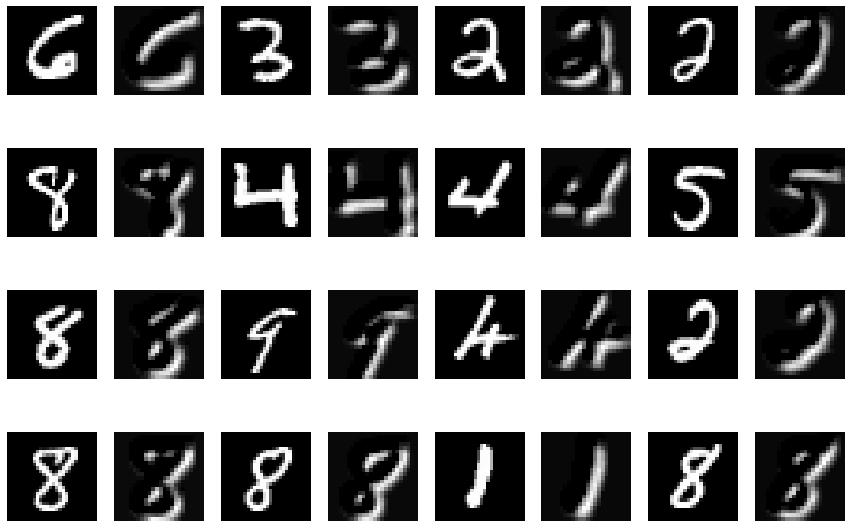

In [16]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n1], cmap='gray')
        axs[i, 2*j+1].axis('off')

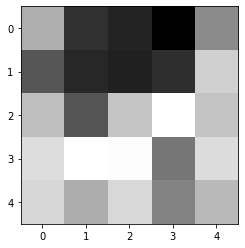

In [17]:
plt.imshow(filters_conv1[:, :, 0, filter_n2], cmap='gray')

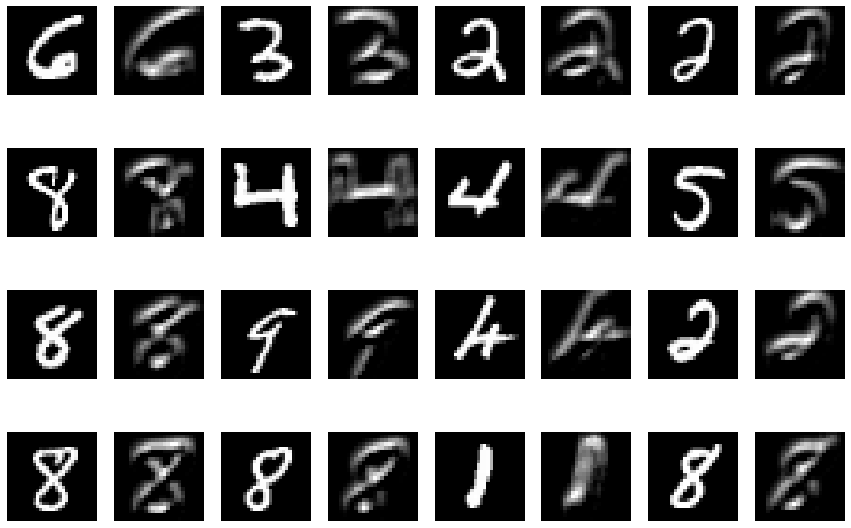

In [18]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n2], cmap='gray')
        axs[i, 2*j+1].axis('off')

Comment on what you see in the feature maps.
* How do they correspond to the original images?
* How do they correspond to the filters?
* Why might the feature maps be helpful for classifying digits?

For example, since fiter #13 is an edge detector for horizontal edges, we can 
see from the corresponding maps that it picks out the structure of horizontal
lines in pictures of numbers. 
Apparently, this can help distinguish between numbers that have horizontal lines
and those without.

### 1.3 Fitting a logistic regression model on feature maps

The features of the images are further summarized after the second convolutional layer.

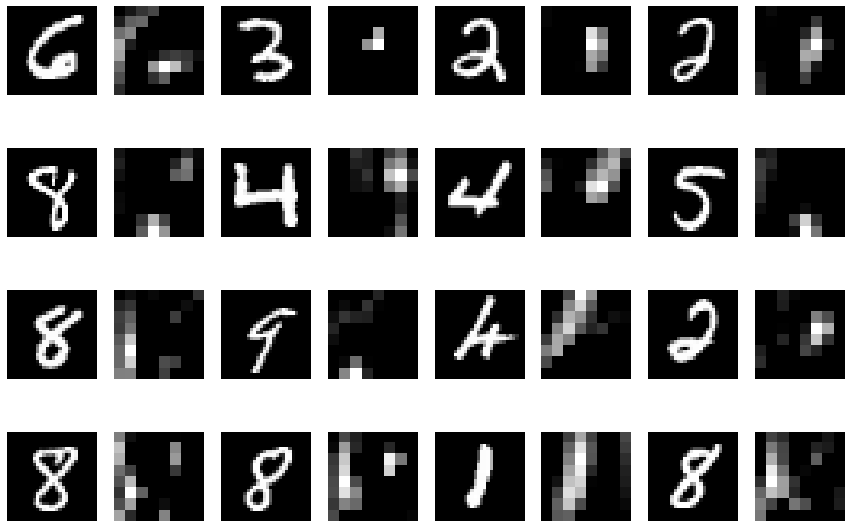

In [19]:
conv2_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('conv2').output)
feature_map_conv2 = conv2_layer_model(x_test)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv2[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j+1].axis('off')

Build and test a logistic regression model to classify two digits of your choice (i.e. a binary classification) using the features maps at the second convolutional layer as the input. You may use logistic regression functions such as [LogisticRegression in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use 80% of the data for training and 20% for test.

* How many features are there in your input X? Show the derivation of this number based on the architecture of the convolutional neural network.

* How is your logistic regression model related to the fully connected layer and softmax layer in the convolutional neural network?

* What is the accuracy of your model? Is this expected, or surprising? 

* Comment on any other aspects of your findings that are interesting to you.


In [20]:
X_lr = np.reshape(feature_map_conv2,(np.shape(feature_map_conv2)[0],-1))
y_lr = y_test

Let's build a model for classification between 7 and 8.

In [21]:
y_7_or_8 = (y_test==7)|(y_test==8)
X_lr = X_lr[y_7_or_8,:]
y_lr = y_test[y_7_or_8]==7

In [22]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size=0.2)
logm_model = LogisticRegression(solver = 'lbfgs').fit(X_lr_train,y_lr_train)
logm_pred = logm_model.predict(X_lr_test)
accuracy = np.mean(logm_pred==y_lr_test)
print("Test accuracy:", accuracy)

Test accuracy: 1.0


Here the test accuracy is 100%.
The number of features is equal to the output shape of the second convolution
layer, which is equal to $8 \times 8 \times 32 = 2048$.

The fully connected layer corresponds to the linear function of the covariates 
in the logistic regression model, and the softmax layer corresponds to the 
logit function.

## Problem 2: All that glitters (20 points)

The 2022 Winter Olympics just finished, and this problem will have you looking forward to summer. You will use Gaussian process regression to model the trends in gold medal performances of selected events in the summer Olympics. The objectives of this problem are for you to:

* Gain experience with Gaussian processes, to better understand how they work
* Explore how posterior inference depends on the properties of the prior mean and kernel
* Use Bayesian inference to identify unusual events
* Practice making your Python code modular and reusable

For this problem, the only starter code we provide is to read in the data and extract 
one event. You may write any GP code that you choose to, but please do not use any 
package for Gaussian processes; your code should be "np.complete" (using only 
basic `numpy` methods). You are encouraged to start from the [GP demo code](https://ydata123.org/sp22/interml/calendar.html) used in class.


When we ran the GP demo code from class on the marathon data, it generated the following plot:
<img src="https://github.com/YData123/sds365-sp22/raw/main/assignments/assn2/marathon.jpg" width="600">

Note several properties of this plot:
* It shows the Bayesian confidence of the regression, as a shaded area. This is a 95% confidence band because it has width given by $\pm 2 \sqrt{V}$, where $V$ is the estimated variance. The variance increases at the right side, for future years.

* The gold medal time for the 1904 marathon is outside of this confidence band. In fact, 
the 1904 marathon was an [unusual event](https://www.smithsonianmag.com/history/the-1904-olympic-marathon-may-have-been-the-strangest-ever-14910747/), and this is apparent from the model. 

* The plot shows the posterior mean, and also shows one random sample from the posterior distribution.

Your task in this problem is generate such a plot for six different Olympic events by writing a function

`def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    ...`
    
 where the input variables are the following:
 
* `year`: a numpy array of years (integers)
* `result`: a numpy array of numerical results, for the gold medal performances in that event
* `kernel`: a kernel function 
* `mean`: a mean function 
* `noise`: a single float for the variance of the noise, $\sigma^2$
* `event_name`: a string used to label the y-axis, for example "marathon min/mile (men's event)"
 
Your function should compute the Gaussian process regression, and then display the resulting plot, analogous to the plot above for the men's marathon event.

You will then process **six** of the events, three men's events and three women's events, and call your function to generate the corresponding six plots.

For each event, you should create a markdown cell that describes the resulting model. Comment on such things as:

* How you chose the kernel, mean, and noise.
* Why the plot does or doesn't look satisfactory to you
* If there are any events such as the 1904 marathon that are notable.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data

Use your best judgement to describe your findings; post questions to EdD if things are unclear. And have fun!



------------------

In the remainder of this problem description, we recall how we processed the marathon data, as an example. The following cell reads in the data and displays the collection of events that are included in the dataset. 

In [23]:
import numpy as np
import pandas as pd

dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/gaussian_processes/olympic_results.csv')
events = set(np.array(dat['Event']))
print(events)

{'Triple Jump Women', '5000M Men', 'Long Jump Women', 'Heptathlon Women', 'Decathlon Men', '3000M Steeplechase Women', '50Km Race Walk Men', '10000M Women', '400M Men', '20Km Race Walk Women', 'High Jump Women', '1500M Men', '4X400M Relay Men', 'Discus Throw Men', 'Marathon Women', '800M Men', '400M Hurdles Women', '800M Women', 'Shot Put Women', '100M Men', 'Hammer Throw Men', '20Km Race Walk Men', 'Triple Jump Men', '4X400M Relay Women', '5000M Women', 'Discus Throw Women', '10000M Men', '3000M Steeplechase Men', 'Long Jump Men', 'High Jump Men', '100M Hurdles Women', '110M Hurdles Men', 'Javelin Throw Men', 'Hammer Throw Women', '1500M Women', '200M Women', 'Pole Vault Men', '4X100M Relay Women', '400M Women', '200M Men', 'Javelin Throw Women', 'Pole Vault Women', '4X100M Relay Men', 'Shot Put Men', '100M Women', 'Marathon Men', '400M Hurdles Men'}


We then process the time to compute the minutes per mile (without checking that the race was actually 26.2 miles!)

In [24]:
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)
    
marathon['Minutes per Mile'] = np.round(mpm,2)
marathon = marathon.drop(columns=['Gender', 'Event'], axis=1)
marathon.reset_index(drop=True, inplace=True)
year = np.array(marathon['Year'])
result = np.array(marathon['Minutes per Mile'])
marathon

,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
0,Athens,1896,G,Spyridon LOUIS,GRE,2:58:50,6.83
1,Paris,1900,G,Michel THÃATO,FRA,2:59:45.0,6.86
2,St Louis,1904,G,Thomas HICKS,USA,3:28:53.0,7.97
3,London,1908,G,John HAYES,USA,2:55:18.4,6.69
4,Stockholm,1912,G,Kennedy Kane MCARTHUR,RSA,2:36:54.8,5.99
5,Antwerp,1920,G,Hannes KOLEHMAINEN,FIN,2:32:35.8,5.82
6,Paris,1924,G,Albin STENROOS,FIN,2:41:22.6,6.16
7,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32:57,5.84
8,Los Angeles,1932,G,Juan Carlos ZABALA,ARG,2:31:36,5.79
9,Berlin,1936,G,Kitei SON,JPN,2:29:19.2,5.70


Enter your code and markdown following this cell.

In [25]:
# mean function
def mu_fn(x, c):
    return np.zeros_like(np.ravel(x)) + c

# kernel function
def K_fn(x, z, h=7):
    K = np.zeros((len(x), len(z)))
    for j in np.arange(K.shape[1]):
        K[:,[j]] = (1/h)*np.exp(-(x-z[j])**2/(2*h**2))
    return K

# main function
def gp_olympic_event(year, results, kernel, mean, noise, event_name):
    Xtrain = year[..., np.newaxis]
    ftrain = results[..., np.newaxis]
    K = kernel(Xtrain, Xtrain)
    xs = np.arange(min(year), max(year)+5, 1.0)[..., np.newaxis]

    K = kernel(Xtrain, Xtrain)
    Ks = kernel(Xtrain, xs)
    Kss = kernel(xs, xs) + noise * np.eye(len(xs))
    Ki = np.linalg.inv(K + noise * np.eye(len(Xtrain)))
    postMu = mean(xs)[..., np.newaxis] + np.dot(Ks.T, np.dot(Ki, (ftrain - mean(Xtrain)[..., np.newaxis])))
    postCov = Kss - np.dot(Ks.T, np.dot(Ki, Ks))

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    mu = np.ravel(postMu)
    S2 = np.diag(postCov)
    f = np.concatenate([mu + 2*np.sqrt(S2), np.flip(mu - 2*np.sqrt(S2), axis=0)])
    ax.fill(np.concatenate([xs, np.flip(xs, axis=0)]), f, color='gray', alpha=0.2)

    z = np.random.normal(0, 1, len(postMu))
    fs = np.linalg.cholesky(postCov) @ z + mu

    ax.plot(xs, fs, color='red', linestyle='-', linewidth=.1)
    ax.plot(xs, mu, color='black', linewidth=.3)
    ax.scatter(Xtrain, ftrain, color='red', marker='o', linewidth=.5)
    ax.set_xlabel('year', fontsize=14)
    _ = ax.set_ylabel('%s' % event_name, fontsize=14)
    plt.show()
    plt.close()

Next, we show a few examples.

In [26]:
polevaultw = dat[dat['Event'] == 'Pole Vault Women']
polevaultw = polevaultw[polevaultw['Medal']=='G']
polevaultw = polevaultw.sort_values('Year')
year = np.array(polevaultw['Year'])
height = np.array(polevaultw['Result'], dtype=float)
polevaultw

,Gender,Event,Location,Year,Medal,Name,Nationality,Result
2328,W,Pole Vault Women,Sydney,2000,G,Stacy DRAGILA,USA,4.6
2334,W,Pole Vault Women,Athens,2004,G,Yelena ISINBAEVA,RUS,4.91
2325,W,Pole Vault Women,Beijing,2008,G,Yelena ISINBAEVA,RUS,5.05
2331,W,Pole Vault Women,London,2012,G,Jennifer SUHR,USA,4.75
2322,W,Pole Vault Women,Rio,2016,G,Ekaterini STEFANIDI,GRE,4.85


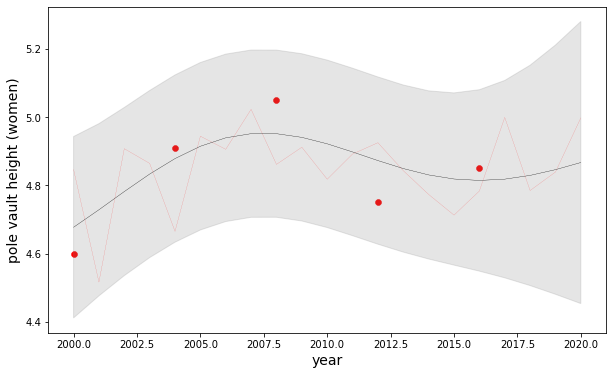

In [27]:
gp_olympic_event(year, height, 
                 kernel = lambda x, z: K_fn(x,z,h=7.5), 
                 mean = lambda x: mu_fn(x, 5), 
                 noise=.01, 
                 event_name='pole vault height (women)')

In [28]:
polevaultm = dat[dat['Event'] == 'Pole Vault Men']
polevaultm = polevaultm[polevaultm['Medal']=='G']
polevaultm = polevaultm.sort_values('Year')
year = np.array(polevaultm['Year'])
height = np.array(polevaultm['Result'], dtype=float)
polevaultm

,Gender,Event,Location,Year,Medal,Name,Nationality,Result
1514,M,Pole Vault Men,Athens,1896,G,William Welles HOYT,USA,3.3
1481,M,Pole Vault Men,Paris,1900,G,Irving BAXTER,USA,3.3
1511,M,Pole Vault Men,St Louis,1904,G,Charles DVORAK,USA,3.5
1476,M,Pole Vault Men,London,1908,G,Alfred Carleten GILBERT,USA,3.71
1477,M,Pole Vault Men,London,1908,G,Edward COOK,USA,3.71
1505,M,Pole Vault Men,Stockholm,1912,G,Harry Stoddard BABCOCK,USA,3.95
1502,M,Pole Vault Men,Paris,1924,G,Lee BARNES,USA,3.95
1499,M,Pole Vault Men,Los Angeles,1932,G,William Waring MILLER,USA,4.315
1473,M,Pole Vault Men,Helsinki,1952,G,Bob RICHARDS,USA,4.55
1470,M,Pole Vault Men,Rome,1960,G,Don BRAGG,USA,4.7


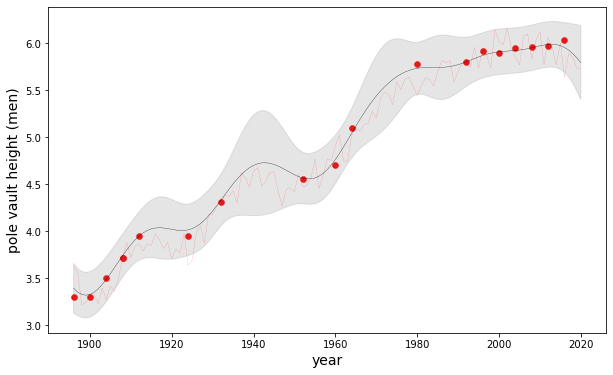

In [29]:
gp_olympic_event(year, height, 
                 kernel = lambda x, z: K_fn(x,z,h=8), 
                 mean = lambda x: mu_fn(x, 5), 
                 noise=.01, 
                 event_name='pole vault height (men)')


In [30]:
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
year = np.array(marathon['Year'])
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)

mpm = np.array(mpm)
marathon['Minutes per Mile'] = mpm
marathon

,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
1456,M,Marathon Men,Athens,1896,G,Spyridon LOUIS,GRE,2:58:50,6.825700
1414,M,Marathon Men,Paris,1900,G,Michel THÃATO,FRA,2:59:45.0,6.860687
1453,M,Marathon Men,St Louis,1904,G,Thomas HICKS,USA,3:28:53.0,7.972646
1411,M,Marathon Men,London,1908,G,John HAYES,USA,2:55:18.4,6.691094
1450,M,Marathon Men,Stockholm,1912,G,Kennedy Kane MCARTHUR,RSA,2:36:54.8,5.989059
1408,M,Marathon Men,Antwerp,1920,G,Hannes KOLEHMAINEN,FIN,2:32:35.8,5.824300
1447,M,Marathon Men,Paris,1924,G,Albin STENROOS,FIN,2:41:22.6,6.159415
1405,M,Marathon Men,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32:57,5.837786
1444,M,Marathon Men,Los Angeles,1932,G,Juan Carlos ZABALA,ARG,2:31:36,5.786260
1402,M,Marathon Men,Berlin,1936,G,Kitei SON,JPN,2:29:19.2,5.699237


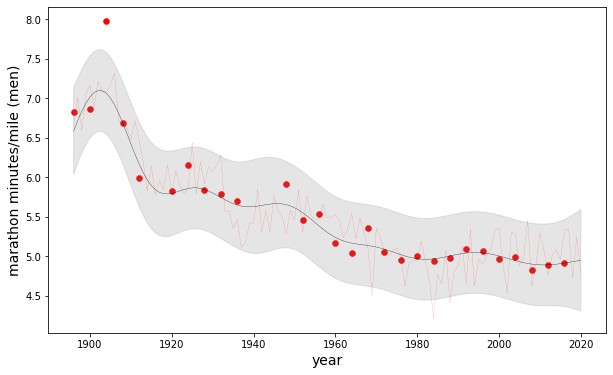

In [31]:
gp_olympic_event(year, mpm, 
                 kernel = lambda x, z: K_fn(x,z,h=8), 
                 mean = lambda x: mu_fn(x, 5), 
                 noise=.05, 
                 event_name='marathon minutes/mile (men)')

In [32]:
m100 = dat[dat['Event'] == '100M Men']
m100 = m100[m100['Medal']=='G']
m100 = m100.sort_values('Year')
year = np.array(m100['Year'])
time = np.array(m100['Result'], dtype=float)
m100['Time'] = time
m100

,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Time
147,M,100M Men,Athens,1896,G,Thomas BURKE,USA,12.0,12.00
108,M,100M Men,Paris,1900,G,Frank JARVIS,USA,11.0,11.00
144,M,100M Men,St Louis,1904,G,Archie HAHN,USA,11.0,11.00
105,M,100M Men,London,1908,G,Reggie WALKER,RSA,10.8,10.80
141,M,100M Men,Stockholm,1912,G,Ralph CRAIG,USA,10.8,10.80
102,M,100M Men,Antwerp,1920,G,Charles PADDOCK,USA,10.8,10.80
138,M,100M Men,Paris,1924,G,Harold ABRAHAMS,GBR,10.6,10.60
99,M,100M Men,Amsterdam,1928,G,Percy WILLIAMS,CAN,10.8,10.80
135,M,100M Men,Los Angeles,1932,G,Eddie TOLAN,USA,10.3,10.30
96,M,100M Men,Berlin,1936,G,Jesse OWENS,USA,10.3,10.30


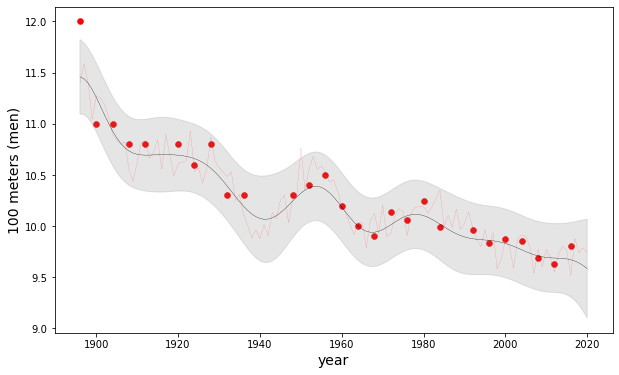

In [33]:
gp_olympic_event(year, time, 
                 kernel = lambda x, z: K_fn(x, z, h=8), 
                 mean = lambda x: mu_fn(x, 9), 
                 noise=.02, 
                 event_name='100 meters (men)')


In [34]:
w100 = dat[dat['Event'] == '100M Women']
w100 = w100[w100['Medal']=='G']
w100 = w100.sort_values('Year')
year = np.array(w100['Year'])
time = np.array(w100['Result'], dtype=float)
w100['Time'] = time
w100

,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Time
1717,W,100M Women,Amsterdam,1928,G,Elizabeth ROBINSON,USA,12.2,12.20
1744,W,100M Women,Los Angeles,1932,G,Stanislawa WALASIEWICZ,POL,11.9,11.90
1714,W,100M Women,Berlin,1936,G,Helen STEPHENS,USA,11.5,11.50
1741,W,100M Women,London,1948,G,Fanny BLANKERS-KOEN,NED,11.9,11.90
1711,W,100M Women,Helsinki,1952,G,Marjorie JACKSON,AUS,11.5,11.50
1738,W,100M Women,Melbourne / Stockholm,1956,G,Betty CUTHBERT,AUS,11.5,11.50
1708,W,100M Women,Rome,1960,G,Wilma RUDOLPH,USA,11.0,11.00
1735,W,100M Women,Tokyo,1964,G,Wyomia TYUS,USA,11.4,11.40
1705,W,100M Women,Mexico,1968,G,Wyomia TYUS,USA,11.0,11.00
1732,W,100M Women,Munich,1972,G,Renate STECHER,GDR,11.07,11.07


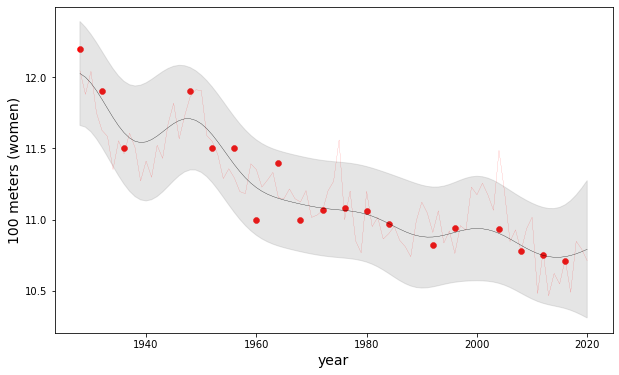

In [35]:
gp_olympic_event(year, time, 
                 kernel = lambda x, z: K_fn(x, z, h=8), 
                 mean = lambda x: mu_fn(x, 11), 
                 noise=.02, 
                 event_name='100 meters (women)')

In [36]:
m5k = dat[dat['Event'] == '5000M Men']
m5k = m5k[m5k['Medal']=='G']
m5k = m5k.sort_values('Year')
year = np.array(m5k['Year'])
result = m5k['Result']
time = []
for tm in result:
    t = np.array(tm.split(':'), dtype=float)
    seconds_ = t[0]*60 + t[1]
    time.append(seconds_)

time = np.array(time)
time = time / 60

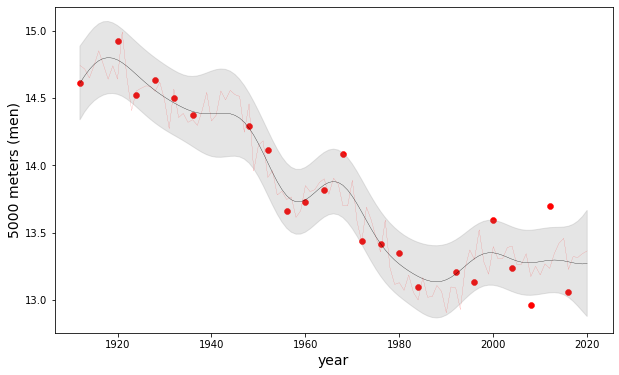

In [ ]:
gp_olympic_event(year, time, 
                 kernel = lambda x, z: K_fn(x, z, h=8), 
                 mean = lambda x: mu_fn(x, 14), 
                 noise=.01, 
                 event_name='5000 meters (men)')

## Problem 3: Double descent! (20 points)

<a href="https://skitheworld.com/2018/12/wurtele-twins-appointed-order-canada/"><img src="https://raw.githubusercontent.com/YData123/sds365-fa22/main/assignments/assn1/double.jpg" width="200" align="left" style="margin:10px 30px 10px 0px"></a>


In this problem you will explore the "double descent" phenomenon that was recently 
discovered as a key principle underlying the performance of deep neural networks.
The problem setup is a "random features" version of a 2-layer neural network. The weights in the first layer are random and fixed, and the weights in the second layer are estimated from data. As we increase the number of neurons in the hidden layer, the dimension $p$ of model increases. It's helpful to define the ratio $\gamma = p/n$ of variables to sample points. If $\gamma < 1$ then we want to use the OLS estimator, and if $\gamma > 1$ we want to use the minimum norm estimator. 
<br>

Your mission (should you choose to accept it), is

1. Implement a function `OLS_or_minimum_norm` that computes the least squares solution when $\gamma < 1$, and the minimum norm solution when $\gamma > 1$. (When $\gamma=1$ the estimator does not, in general, exist.)
1. Run the main code we give you to average over many trials, and to compute and plot the estimated risk for a range of values of $\gamma$. 
1. Next, extend the starter code so that you compute (estimates of) the squared-bias and variance of the models. To do this, note that you'll need access to the true regression function, which is provided. You may want to refer to the demo code for smoothing kernels as an example.
1. Using your new code, extend the plotting function we provide so that you plot 
the squared-bias, variance, and risk together on the same plot. 
1. Finally, comment on the results, describing why it might make sense that the squared bias, variance, and risk have the given shapes that they do.
1. Show that in the overparameterized regime $\gamma > 1$, as $\lambda \to 0$, the ridge regression estimator converges to the minimum norm estimator.


By doing this exercise you will solidify your understanding of the meaning of bias and variance, and also gain a better understanding of the "double descent" phenomenon for overparameterized neural networks, 
and their striking resistance to overfitting.

We're available in OH to help with any issues you run into!

If you have any interest in background reading on this topic (not expected or required), we recommend Hastie et al., ["Surprises in high-dimensional ridgeless least squares regression"](https://www.stat.cmu.edu/~ryantibs/papers/ridgeless.pdf).



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 3.1

Implement the function `OLS_or_minimum_norm` that computes the OLS solution for $\gamma < 1$, and the minimum norm solution for $\gamma > 1$.

In [ ]:
def OLS_or_minimum_norm(X, y):
    (n, p) = (X.shape[0], X.shape[1])
    if n > p:
        betahat = np.linalg.inv(X.T @ X) @ X.T @ y
    else:
        betahat = X.T @ np.linalg.inv(X @ X.T) @ y
    return betahat

In [ ]:
def plot_double_descent_risk(gammas, risk, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(10,6))
    a = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            a[i] = gammas[i] * 10
        else:
            a[i] = gammas[i] + 9
    ax.axvline(x=a[np.array(gammas)==1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma, linestyle='dashed', color='gray')
    ax.scatter(a, risk, color='salmon')
    ax.plot(a, risk, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    tick_pos = [a[j] for j in np.arange(len(a)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(tick_pos)
    ax.xaxis.set_ticklabels(tickgam)

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    _ = plt.ylabel('Risk', fontsize=18)

### Data setup 

The following cell sets up our data. The inputs $X$ are 
random Gaussian vectors of dimension $d=10$. Then, we map these 
using a neural network with fixed, Gaussian weights, to get random features
corresponding to $p^* = 150$ hidden neurons. The second layer 
coefficients are $\beta^* \in {\mathbb R}^{p^*}$, which are fixed. 
This defines the true model.


In [ ]:
np.random.seed(123456)

sigma = 1
d = 10
p_star = 150
signal_size = 5

W_star = (1/np.sqrt(d)) * np.random.randn(d, p_star)
beta_star = np.arange(p_star)
beta_star = signal_size * beta_star / np.sqrt(np.sum(beta_star**2))

N = 10000
X = np.random.randn(N, d)

# f_star is the true regression function, for computing the squared bias
f_star = np.dot(np.tanh(np.dot(X, W_star)), beta_star)
noise = sigma * np.random.randn(N)
y = f_star + noise
yf = np.concatenate((y.reshape(N,1), f_star.reshape(N,1)), axis=1)

### Train a sequence of models for different values of $\gamma$

Next, we train a sequence of models for different values of $\gamma$, always 
fixing the sample size at $n=200$, but varying the dimension $p = \gamma n$. 
When $p < p^*$ we just take the first $p$ features in the true model. 
When $p > p^*$ we add $p-p^*$ neurons to the hidden layer, with their 
own random weights.

In the code below, we loop over the different values of $\gamma$, 
and for each $\gamma$ we run $100$ trials, each time generating 
a new training set of size $n=200$. The model (either OLS or minimum norm) is then computed, the MSE is computed, and finally the risk is estimated by averaging over all $100$ trials.


In [ ]:

trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
risk = []
estimates = []
_, X_test, _, yf_test = train_test_split(X, yf, train_size=1, test_size=1000)

for gamma in gammas:
    err = []
    estimates_g = []
    p = int(n * gamma)
    if gamma == 1:
        risk.append(np.inf)
        continue
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:,:min(p, p_star)] = W_star[:,:min(p, p_star)]
    for i in np.arange(trials):
        X_train, _, yf_train, _ = train_test_split(X, yf, train_size=n, test_size=1000)
        H_train = np.tanh(np.dot(X_train, W))
        H_test = np.tanh(np.dot(X_test, W))
        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])
        yhat_test = H_test @ beta_hat 
        err.append(np.mean((yhat_test - yf_test[:,0])**2))
        estimates_g.append(yhat_test)
    estimates.append(estimates_g)
    print('gamma=%.2f  p=%d  n=%d  risk=%.3f' % (gamma, p, n, np.mean(err)))
    risk.append(np.mean(err))


gamma=0.01  p=2  n=200  risk=7.898
gamma=0.05  p=10  n=200  risk=4.242
gamma=0.10  p=20  n=200  risk=2.352
gamma=0.20  p=40  n=200  risk=2.249
gamma=0.30  p=60  n=200  risk=2.375
gamma=0.40  p=80  n=200  risk=2.585
gamma=0.50  p=100  n=200  risk=3.033
gamma=0.60  p=120  n=200  risk=3.629
gamma=0.70  p=140  n=200  risk=4.377
gamma=0.80  p=160  n=200  risk=6.599
gamma=0.90  p=180  n=200  risk=16.507
gamma=0.92  p=184  n=200  risk=21.294
gamma=0.94  p=188  n=200  risk=28.646
gamma=1.10  p=220  n=200  risk=22.820
gamma=1.20  p=240  n=200  risk=14.028
gamma=1.40  p=280  n=200  risk=8.199
gamma=1.60  p=320  n=200  risk=6.569
gamma=2.00  p=400  n=200  risk=5.157
gamma=3.00  p=600  n=200  risk=3.944
gamma=4.00  p=800  n=200  risk=3.618
gamma=5.00  p=1000  n=200  risk=3.433
gamma=6.00  p=1200  n=200  risk=3.192
gamma=7.00  p=1400  n=200  risk=3.206
gamma=8.00  p=1600  n=200  risk=3.083
gamma=9.00  p=1800  n=200  risk=3.058
gamma=10.00  p=2000  n=200  risk=3.050


### Plot the risk

At this point, you can plot the risk by just evaluating the cell below. 
This should reveal the "double descent" behavior.


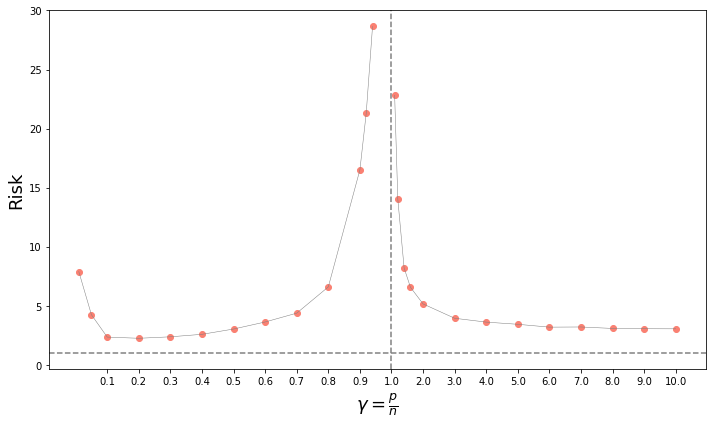

In [ ]:
plot_double_descent_risk(gammas, risk, sigma)
plt.tight_layout()
plt.savefig('double_descent_risk.jpg')

### Problem 3.2

Comment on the results. Explain why the risk plot does or does not make sense 
in each regime: The underparameterized regime $\gamma < 1$, and the overparameterized 
regime $\gamma > 1$. Is the curve "U-shaped" in the underparameterized regime? Why or why not?
What about in the overparameterized regime? You will be able to give better answers to these questions when you estimate the bias and variance below.


When $\gamma<1$, the curve show a U-shape, which is expected due to the bias-variance tradeoff where bias squared decreases and variance increases as $p$ increases. 
When $\gamma>1$, the risk keeps decreasing as $\gamma$ increases.

### Problem 3.3

Now, modify the above code so that you can estimate both the squared bias and the 
variance of the estimator. Before you do this, you may want to revisit the kernel smoothing demo from class, where we computed the squared bias, variance, and risk. You'll need the true function, which is provided in the variable `yf`.  You should not have to write a lot of code, but can compute the bias and variance after you store the predicted values on the test data for each trial.

Plot the results, by plotting both the squared bias, the variance, and the risk for the sequence of gammas. To do this you will have to modify the plotting function appropriately, but this again involves minimal changes. When you obtain your final plot, comment 
on the shape of the bias and variance curves, as above for Problem 3.2.



In [ ]:
yhat = np.array(estimates)
bias = np.mean(yhat, axis=1)  -  yf_test[:,1]
biassq = np.mean(bias**2, axis=1)
yhatvar = np.var(yhat, axis=1)
var = np.mean(yhatvar, axis=1)

In [ ]:
ind = np.where(np.array(gammas)==1)[0][0]
gammas[ind]
squared_bias = np.array(list(biassq[:ind]) + [np.inf] + list(biassq[ind:]))
variance = np.array(list(var[:ind]) + [np.inf] + list(var[ind:]))

In [ ]:
def plot_double_descent_bias_variance(gammas, risk, biassq, variance, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(12,8))
    a = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            a[i] = gammas[i] * 10
        else:
            a[i] = gammas[i] + 9
    ax.axvline(x=a[np.array(gammas)==1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma, linestyle='dashed', color='gray')
    
    risky = biassq + variance + sigma
    ax.scatter(a, risky, color='salmon', label='risk')
    ax.plot(a, risky, color='gray', linewidth=.5)
    ax.scatter(a, biassq, color='lightblue', label='squared bias')
    ax.plot(a, biassq, color='gray', linewidth=.5)
    ax.scatter(a, variance, color='lightgreen', label='variance')
    ax.plot(a, variance, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    tick_pos = [a[j] for j in np.arange(len(a)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(tick_pos)
    ax.xaxis.set_ticklabels(tickgam)

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    plt.legend()
    _ = plt.ylabel('Risk', fontsize=18)

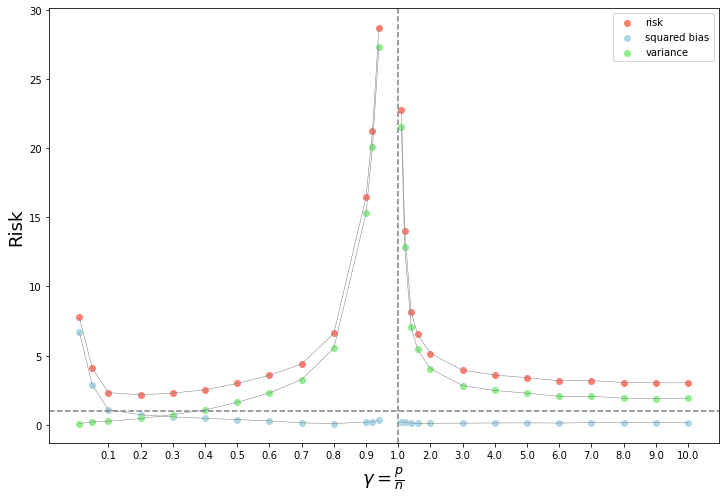

In [ ]:
plot_double_descent_bias_variance(gammas, risk, squared_bias, variance, sigma)
plt.savefig('double_descent_bv.pdf') 

### Problem 3.4

In class, we discussed the interpretation of the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. Geometrically, we can describe $ \hat{\beta}_{\text{mn}} $ as the orthogonal projection of the zero vector in $ \mathbb{R}^p $ onto the $ (p-1) $-dimensional hyperplane $ \{ \beta : X\beta = Y \} $.  

This can also be viewed as "ridgeless" regression. In ridge regression, we minimize the objective function
$$
\| Y - X\beta  \|_2^2 + \lambda \| \beta \|_2^2,
$$
which has the closed-form solution
$$
\hat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T Y.
$$

In the overparameterized regime where $ p > n $, it can be shown that as $ \lambda \to 0 $, $ \hat{\beta}_{\lambda} $ converges to $ \hat{\beta}_{\text{mn}} $. 

Your task is to show that as $ \lambda \to 0 $, the limit of the ridge regression estimator $ \hat{\beta}_{\lambda} $, in the overparameterized regime where $ \gamma > 1 $, is the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. You may want to use the Woodbury formula for this derivation.


_Hint_:
1. Applying the simplified version of Woodbury formula
$$
(I + UV^T)^{-1} = I - U(I + V^T U)^{-1} V^T.
$$ 
we can derive the identity:
$$
(X^T X + \lambda I_p)^{-1} X^T = X^T (X X^T + \lambda I_n)^{-1},
$$
2. You might need to use the woodbury formula twice.



Solution:
We aim to show that as $ \lambda \to 0 $, the ridge regression estimator $ \hat{\beta}_{\lambda} $ converges to the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $ in the overparameterized regime where $ \gamma > 1 $.
The closed-form solution for $ \hat{\beta}_{\lambda} $ in ridge regression is:
$$
\hat{\beta}_{\lambda} = (X^T X + \lambda I_p)^{-1} X^T Y.
$$
First, We apply
$$
(I + UV^T)^{-1} = I - U(I + V^T U)^{-1} V^T
$$
to both $(\lambda I_p + X^T X)^{-1}X^T$ and $X^T (\lambda I_n + X X^T)^{-1}$ to show they are equal.

For $(\lambda I_p + X^T X)^{-1}X^T$, let $ U = X^T/\lambda $ and $ V^T = X $. Applying these into the Woodbury formula gives:
\begin{align}
(\lambda I_p + X^T X)^{-1}X^T &= \frac{1}{\lambda} (I_p + \frac{X^T X}{\lambda})^{-1}X^T \\ &= \frac{1}{\lambda}(I_p - \frac{X^T}{\lambda} (I_n + \frac{X X^T}{\lambda})^{-1} X)X^T.
\end{align}

For $X^T (\lambda I_n + X X^T)^{-1}$ , let $ U = I_n $ and $ V^T = X X^T/\lambda$. Applying these into the Woodbury formula gives:
\begin{align}
X^T (\lambda I_n + X X^T)^{-1} &= \frac{X^T}{\lambda}(I_n + \frac{X X^T}{\lambda})^{-1} \tag{3} \\ &= \frac{X^T}{\lambda}(I_n - (I_n + \frac{X X^T}{\lambda})^{-1} \frac{X X^T}{\lambda}) \tag{4}
\end{align}

Multiplying out and compare each term, it's easy to see that (2) = (4), therefore $$(\lambda I_p + X^T X)^{-1}X^TY = X^T (\lambda I_n + X X^T)^{-1}Y$$ Now we can take $\lambda \to 0$, which yields the minimum norm solution.
